# Project: Diagnostic reasoning assistant

**Author:** Julia Parnis 
**Date:** February 7, 2026  
**Project:** Data Science Bootcamp - Final Projec

## Project Overview

**Goal:** Build an AI-powered diagnostic assistant that provides ranked differential diagnoses through iterative questioning, with enhanced detection of rare and overlooked conditions.

**Key Innovation:** Two-tier ML architecture combined with RAG (Retrieval-Augmented Generation) for transparent clinical reasoning and literature-backed rare disease identification.

**Dataset:** DDXPlus - 1.3M synthetic patient cases, 49 pathologies  
**Source:** [Hugging Face](https://huggingface.co/datasets/aai530-group6/ddxplus)
**Citation:** Fansi Tchango et al. (2022)

**Note:** This is a synthetic dataset (computer-generated from medical knowledge bases) designed for research and education. It provides a robust, privacy-compliant foundation for developing diagnostic AI systems.

# Notebook 1: Data Exploration

**Objective:** Load and explore the DDXPlus dataset to understand structure, quality, and feature distributions.

**Tasks:**
1. Load and inspect dataset structure
2. Fix data type issues
3. Assess data quality (missing values, duplicates)
4. Visualize key patterns (diseases, demographics, symptoms)
5. Analyze evidence and condition mappings
6. Save processed data for modeling


## 1. Setup & Data Loading

In [1]:
# 1.1 Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast
import os
from collections import Counter
from datasets import load_dataset, concatenate_datasets

print("✓ Libraries imported")


c:\Users\julia\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries imported


In [2]:
# 1.2 Display Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("✓ Display settings configured")


✓ Display settings configured


In [3]:
# 1.3 Visualization Settings (Academic Style - Colorblind Safe)
plt.style.use('seaborn-v0_8-white')
sns.set_context("talk", font_scale=0.9)

# IBM Design colorblind-safe palette
IBM_COLORS = {
    'blue': '#648FFF',
    'purple': '#785EF0', 
    'magenta': '#DC267F',
    'orange': '#FE6100',
    'yellow': '#FFB000',
    'teal': '#06A39B',
    'gray': '#5F6368'
}

# Figure parameters
FIGSIZE_SINGLE = (10, 6)
FIGSIZE_DOUBLE = (14, 6)
DPI = 300  # High resolution for presentations

print("✓ Visualization settings configured")


✓ Visualization settings configured


In [20]:
# 1.4 Load Dataset from Hugging Face
from datasets import load_dataset

dataset = load_dataset("aai530-group6/ddxplus")

print(f"✓ Dataset loaded from Hugging Face")
print(f"\nSplit breakdown:")
print(f"  Train:      {len(dataset['train']):>8,} examples ({len(dataset['train'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Validation: {len(dataset['validate']):>8,} examples ({len(dataset['validate'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Test:       {len(dataset['test']):>8,} examples ({len(dataset['test'])/sum([len(dataset[s]) for s in dataset])*100:.1f}%)")
print(f"  Total:      {sum([len(dataset[s]) for s in dataset]):>8,} examples")


✓ Dataset loaded from Hugging Face

Split breakdown:
  Train:      1,025,602 examples (79.3%)
  Validation:  132,448 examples (10.2%)
  Test:        134,529 examples (10.4%)
  Total:      1,292,579 examples


In [5]:
type(dataset)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 1025602
    })
    test: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 134529
    })
    validate: Dataset({
        features: ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE'],
        num_rows: 132448
    })
})


**Observation:** Dataset comes pre-split into train/validation/test sets and appears in datasets.dataset_dict.DatasetDict format.

**Decision:** Convert to pandas format for easier EDA and combine all splits for comprehensive EDA. We'll respect the original splits during modeling.


In [21]:
# 1.5 Combine Splits and Convert to Pandas
from datasets import concatenate_datasets

# Combine all splits
all_data = concatenate_datasets([
    dataset['train'], 
    dataset['validate'], 
    dataset['test']
])

# Convert to pandas DataFrame for easier EDA
df_all = all_data.to_pandas()

print(f"✓ Converted to pandas DataFrame: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")


✓ Converted to pandas DataFrame: 1,292,579 rows × 6 columns


In [7]:
# 1.6 Load Mapping Files (Evidences and Conditions)
# Load evidence codes (symptoms/findings)
with open('data/release_evidences.json', 'r', encoding='utf-8') as f:
    evidences = json.load(f)

# Load condition codes (diseases)
with open('data/release_conditions.json', 'r', encoding='utf-8') as f:
    conditions = json.load(f)

print(f"✓ Mapping files loaded:")
print(f"  Evidences (symptoms/findings): {len(evidences)} codes; \nType: {type(evidences)}")
print(f"  Conditions (diseases):         {len(conditions)} codes; \nType: {type(conditions)}")


✓ Mapping files loaded:
  Evidences (symptoms/findings): 223 codes; 
Type: <class 'dict'>
  Conditions (diseases):         49 codes; 
Type: <class 'dict'>


In [22]:
# 1.7 Inspect JSON File Structure

print("="*70)
print("EVIDENCE MAPPING STRUCTURE")
print("="*70)

# Show one example evidence
sample_evidence_code = list(evidences.keys())[0]
print(f"\nSample evidence code: {sample_evidence_code}")
print(f"Structure:")
print(json.dumps(evidences[sample_evidence_code], indent=2))

# Check what fields are available
sample_fields = evidences[sample_evidence_code].keys()
print(f"\nAvailable fields in evidence mapping: {list(sample_fields)}")

print("\n" + "="*70)
print("CONDITION MAPPING STRUCTURE")
print("="*70)

# Show one example condition
sample_condition = list(conditions.keys())[0]
print(f"\nSample condition: {sample_condition}")
print(f"Structure (first 500 characters):")
print(json.dumps(conditions[sample_condition], indent=2)[:500] + "...")

# Check what fields are available
sample_fields = conditions[sample_condition].keys()
print(f"\nAvailable fields in condition mapping: {list(sample_fields)}")

print("\n✓ JSON files are Python dictionaries - ready to use for lookups")



EVIDENCE MAPPING STRUCTURE

Sample evidence code: E_91
Structure:
{
  "name": "E_91",
  "code_question": "E_91",
  "question_fr": "Avez-vous objectiv\u00e9 ou ressenti de la fi\u00e8vre?",
  "question_en": "Do you have a fever (either felt or measured with a thermometer)?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}

Available fields in evidence mapping: ['name', 'code_question', 'question_fr', 'question_en', 'is_antecedent', 'default_value', 'value_meaning', 'possible-values', 'data_type']

CONDITION MAPPING STRUCTURE

Sample condition: Spontaneous pneumothorax
Structure (first 500 characters):
{
  "condition_name": "Spontaneous pneumothorax",
  "cond-name-fr": "Pneumothorax spontan\u00e9",
  "cond-name-eng": "Spontaneous pneumothorax",
  "icd10-id": "J93",
  "symptoms": {
    "E_55": {},
    "E_53": {},
    "E_57": {},
    "E_54": {},
    "E_59": {},
    "E_56": {},
    "E_58": {},
    "E_66": {},
    "E_220": 

## 2. Initial Data Inspection

**Purpose:** Understand data structure and identify/fix type issues before analysis.


In [ ]:
# 2.1 Dataset Structure Overview
print("="*70)
print("DATASET STRUCTURE")
print("="*70)

print(f"\nShape: {df_all.shape}")
print(f"Rows: {df_all.shape[0]:,}")
print(f"Columns: {df_all.shape[1]}")

print("\nColumn Names:")
for i, col in enumerate(df_all.columns, 1):
    print(f"  {i}. {col}")

print("\nFirst 3 rows:")
display(df_all.head(3))

print("\nBasic statistics:")
display(df_all.describe())
print(f"Sex: {df_all['SEX'].value_counts().to_dict()}")


DATASET STRUCTURE

Shape: (1292579, 6)
Rows: 1,292,579
Columns: 6

Column Names:
  1. AGE
  2. DIFFERENTIAL_DIAGNOSIS
  3. SEX
  4. PATHOLOGY
  5. EVIDENCES
  6. INITIAL_EVIDENCE

First 3 rows:


,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366], ['URTI', 0.16078097198...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_55_@_V_89', 'E_55_@_V_108', 'E_55_@_...",E_91
1,21,"[['HIV (initial infection)', 0.5189500564407601], ['Chagas', 0.3217819010436332], ['Scombroid fo...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_@_V_198', 'E_55_@_V_62', 'E_55_@_V_166', 'E_55_@_V...",E_50
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumonia', 0.10048134562119852], ['Unstable angina', 0....",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55_@_V_29', 'E_55_@_V_55', 'E_55_@_V_56', 'E_55_@_V_...",E_77



Basic statistics:


,AGE
count,1.292579e+06
mean,3.972967e+01
std,2.272213e+01
min,0.000000e+00
25%,2.200000e+01
50%,3.900000e+01
75%,5.600000e+01
max,1.090000e+02


In [24]:
# 2.2 Data Type Investigation
print("="*70)
print("DATA TYPE INSPECTION")
print("="*70)

# Show overview
df_all.info()

# Identify string-encoded lists/dicts
print("\n" + "Checking for string-encoded data structures...")
problem_cols = []

for col in df_all.columns:
    sample = df_all[col].iloc[0]
    if isinstance(sample, str) and (sample.startswith('[') or sample.startswith('{')):
        problem_cols.append(col)
        print(f"  ⚠️  {col}: Currently {type(sample).__name__}, should be {'list' if sample.startswith('[') else 'dict'}")

if not problem_cols:
    print("  ✓ All data types are correct")
else:
    print(f"\n{len(problem_cols)} column(s) need type conversion")


DATA TYPE INSPECTION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1292579 entries, 0 to 1292578
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   AGE                     1292579 non-null  int64 
 1   DIFFERENTIAL_DIAGNOSIS  1292579 non-null  object
 2   SEX                     1292579 non-null  object
 3   PATHOLOGY               1292579 non-null  object
 4   EVIDENCES               1292579 non-null  object
 5   INITIAL_EVIDENCE        1292579 non-null  object
dtypes: int64(1), object(5)
memory usage: 59.2+ MB

Checking for string-encoded data structures...
  ⚠️  DIFFERENTIAL_DIAGNOSIS: Currently str, should be list
  ⚠️  EVIDENCES: Currently str, should be list

2 column(s) need type conversion


### Data Type Issue Discovered

**Problem:** Columns `EVIDENCES` and `DIFFERENTIAL_DIAGNOSIS` are stored as strings instead of Python lists.

**Example:**
- String: `"['E_48', 'E_50', 'E_53']"` (221 characters)
- Should be: `['E_48', 'E_50', 'E_53']` (3 items)

**Impact:** Using `len()` counts characters instead of list items → wrong symptom counts (240 vs 20).

**Fix:** Convert strings to proper Python data structures using `ast.literal_eval()`.


In [25]:
# 2.3 Create List Columns from String Representations
import ast

print("Creating list versions while preserving original string columns...")

#  EVIDENCES and DIFFERENTIAL_DIAGNOSIS: Convert string representation to Python list, Create NEW list columns 
df_all['EVIDENCES_list'] = df_all['EVIDENCES'].apply(ast.literal_eval)
df_all['DIFFERENTIAL_DIAGNOSIS_list'] = df_all['DIFFERENTIAL_DIAGNOSIS'].apply(ast.literal_eval)

# Verification
print("\nVerification:")
patient0 = df_all.iloc[0]
print(f"  EVIDENCES type: {type(patient0['EVIDENCES_list'])}")
print(f"  EVIDENCES sample: {patient0['EVIDENCES_list'][:5]}")
print(f"  EVIDENCES count: {len(patient0['EVIDENCES_list'])} items")
print(f"\n  DIFFERENTIAL_DIAGNOSIS type: {type(patient0['DIFFERENTIAL_DIAGNOSIS_list'])}")
print(f"  DIFFERENTIAL_DIAGNOSIS sample: {patient0['DIFFERENTIAL_DIAGNOSIS_list'][:2]}")


Creating list versions while preserving original string columns...

Verification:
  EVIDENCES type: <class 'list'>
  EVIDENCES sample: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183']
  EVIDENCES count: 19 items

  DIFFERENTIAL_DIAGNOSIS type: <class 'list'>
  DIFFERENTIAL_DIAGNOSIS sample: [['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.17579340398940366]]


In [26]:
# 2.4 Create Derived Columns
print("Creating derived columns...")

# Count number of evidences (symptoms/findings) per patient
df_all['num_evidences'] = df_all['EVIDENCES_list'].apply(len)

print(f"\n✓ Derived columns created:")
print(f"  num_evidences:           \n{df_all['num_evidences'].describe()}")

Creating derived columns...

✓ Derived columns created:
  num_evidences:           
count    1.292579e+06
mean     1.977426e+01
std      8.012032e+00
min      2.000000e+00
25%      1.500000e+01
50%      2.000000e+01
75%      2.500000e+01
max      4.700000e+01
Name: num_evidences, dtype: float64


## 3. Data Quality Assessment

**Purpose:** Check for missing values, duplicates, and data integrity issues.


In [27]:
# 3.1 Missing Values
print("="*70)
print("MISSING VALUES CHECK")
print("="*70)

missing = df_all.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n✓ No missing values found - dataset is complete")
else:
    print(f"\n⚠️  {missing.sum()} missing values found")


MISSING VALUES CHECK
AGE                            0
DIFFERENTIAL_DIAGNOSIS         0
SEX                            0
PATHOLOGY                      0
EVIDENCES                      0
INITIAL_EVIDENCE               0
EVIDENCES_list                 0
DIFFERENTIAL_DIAGNOSIS_list    0
num_evidences                  0
dtype: int64

✓ No missing values found - dataset is complete


In [29]:
# 3.2 Duplicate Rows
print("="*70)
print("DUPLICATE CHECK")
print("="*70)

original_cols = ['AGE', 'DIFFERENTIAL_DIAGNOSIS', 'SEX', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
duplicates = df_all.duplicated(subset=original_cols).sum()
print(f"Duplicate rows (all columns): {duplicates}")

if duplicates == 0:
    print("✓ No duplicate rows found - all 1,292,579 cases are unique")
else:
    print(f"⚠️  {duplicates} duplicate rows detected")


DUPLICATE CHECK
Duplicate rows (all columns): 13913
⚠️  13913 duplicate rows detected


In [30]:
# 3.2.1 Investigate the Duplicates
print("\n" + "="*70)
print("DUPLICATE INVESTIGATION")
print("="*70)

# Get the duplicate rows
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_rows = df_all[duplicate_mask]

print(f"Total duplicate rows: {len(duplicate_rows):,}")
print(f"Percentage of dataset: {len(duplicate_rows)/len(df_all)*100:.2f}%")

# How many unique cases are duplicated?
unique_duplicate_cases = df_all[duplicate_mask].drop_duplicates(subset=original_cols)
print(f"Number of unique patterns that are duplicated: {len(unique_duplicate_cases):,}")

# Show examples
print("\nExample of duplicate rows:")
print("-"*70)
# Get one duplicate set
first_duplicate = df_all[duplicate_mask].iloc[0]
same_rows = df_all[
    (df_all['AGE'] == first_duplicate['AGE']) &
    (df_all['SEX'] == first_duplicate['SEX']) &
    (df_all['PATHOLOGY'] == first_duplicate['PATHOLOGY']) &
    (df_all['EVIDENCES'] == first_duplicate['EVIDENCES']) &
    (df_all['DIFFERENTIAL_DIAGNOSIS'] == first_duplicate['DIFFERENTIAL_DIAGNOSIS']) &
    (df_all['INITIAL_EVIDENCE'] == first_duplicate['INITIAL_EVIDENCE'])
]

print(f"\nThis pattern appears {len(same_rows)} times:")
print(f"  Age: {first_duplicate['AGE']}")
print(f"  Sex: {first_duplicate['SEX']}")
print(f"  Disease: {first_duplicate['PATHOLOGY']}")
print(f"  Initial evidence: {first_duplicate['INITIAL_EVIDENCE']}")
print(f"  Number of symptoms: {len(first_duplicate['EVIDENCES_list'])}")



DUPLICATE INVESTIGATION
Total duplicate rows: 26,227
Percentage of dataset: 2.03%
Number of unique patterns that are duplicated: 12,314

Example of duplicate rows:
----------------------------------------------------------------------

This pattern appears 2 times:
  Age: 49
  Sex: F
  Disease: Allergic sinusitis
  Initial evidence: E_169
  Number of symptoms: 10


### Analysis & Decision on Duplicates

**Findings:**
- 26,227 total rows involved in duplicates (2.03% of dataset)
- 12,314 unique patterns that appear multiple times
- 13,913 duplicate rows (extra copies) if keeping first occurrence
- Most patterns appear exactly 2 times

**Solution: Remove duplicates BUT preserve frequency information**

We'll create a `frequency` column that counts how many times each pattern appears. This approach:
- ✅ Removes redundant data (cleaner training)
- ✅ Preserves information about pattern frequency
- ✅ Enables sample weighting in model training

In [31]:
# Analyze duplication patterns
duplicate_mask = df_all.duplicated(subset=original_cols, keep=False)
duplicate_counts = df_all[duplicate_mask].groupby(original_cols, dropna=False).size()

print("Duplication frequency distribution:")
print(f"  Patterns appearing 2 times: {(duplicate_counts == 2).sum():,}")
print(f"  Patterns appearing 3 times: {(duplicate_counts == 3).sum():,}")
print(f"  Patterns appearing 4+ times: {(duplicate_counts >= 4).sum():,}")
print(f"  Maximum copies: {duplicate_counts.max()}")


Duplication frequency distribution:
  Patterns appearing 2 times: 10,784
  Patterns appearing 3 times: 1,461
  Patterns appearing 4+ times: 69
  Maximum copies: 4


In [32]:
# 3.2.2 Count Duplicates Before Removal
print("="*70)
print("COUNTING DUPLICATE FREQUENCIES")
print("="*70)

# Count how many times each pattern appears
df_all['frequency'] = df_all.groupby(original_cols, dropna=False)[original_cols[0]].transform('count')

# Show distribution
print("Frequency distribution:")
print(df_all['frequency'].value_counts().sort_index())

print(f"\nRows appearing once:  {(df_all['frequency'] == 1).sum():,} ({(df_all['frequency'] == 1).sum()/len(df_all)*100:.1f}%)")
print(f"Rows appearing 2+ times: {(df_all['frequency'] >= 2).sum():,} ({(df_all['frequency'] >= 2).sum()/len(df_all)*100:.1f}%)")
print(f"Maximum frequency: {df_all['frequency'].max()}")

print("\n✓ Frequency column created")


COUNTING DUPLICATE FREQUENCIES
Frequency distribution:
frequency
1    1266352
2      21568
3       4383
4        276
Name: count, dtype: int64

Rows appearing once:  1,266,352 (98.0%)
Rows appearing 2+ times: 26,227 (2.0%)
Maximum frequency: 4

✓ Frequency column created


In [33]:
# 3.2.3 Remove Duplicates (Keep Frequency Info)
print("\n" + "="*70)
print("REMOVING DUPLICATES (PRESERVING FREQUENCY)")
print("="*70)

original_count = len(df_all)

# Remove duplicates but keep the frequency column
df_all = df_all.drop_duplicates(subset=original_cols, keep='first').reset_index(drop=True)

removed_count = original_count - len(df_all)

print(f"Original rows:        {original_count:,}")
print(f"Rows removed:         {removed_count:,}")
print(f"Unique rows:          {len(df_all):,}")

print(f"\n✓ Duplicates removed")
print(f"✓ 'frequency' column preserved for sample weighting")

# Verify
print(f"\nFrequency column summary:")
print(f"  Patterns that were unique: {(df_all['frequency'] == 1).sum():,}")
print(f"  Patterns that were duplicated: {(df_all['frequency'] >= 2).sum():,}")
print(f"  Total weighted samples: {df_all['frequency'].sum():,} (original dataset size)")



REMOVING DUPLICATES (PRESERVING FREQUENCY)
Original rows:        1,292,579
Rows removed:         13,913
Unique rows:          1,278,666

✓ Duplicates removed
✓ 'frequency' column preserved for sample weighting

Frequency column summary:
  Patterns that were unique: 1,266,352
  Patterns that were duplicated: 12,314
  Total weighted samples: 1,292,579 (original dataset size)


In [35]:
# 3.3 Save Cleaned Dataset
print("="*70)
print("SAVING CLEANED DATASET")
print("="*70)

import os

# Create directory
os.makedirs('data/processed', exist_ok=True)

# Save cleaned data 
df_all.to_pickle('data/processed/ddxplus_all.pkl')

# Get file info
file_size_mb = os.path.getsize('data/processed/ddxplus_all.pkl') / (1024 * 1024)

print(f"✓ Saved: data/processed/ddxplus_all.pkl")
print(f"  Rows: {len(df_all):,}")
print(f"  Columns: {len(df_all.columns)}")
print(f"  Size: {file_size_mb:.1f} MB")
print(f"\n✓ Ready for exploratory analysis (Section 4)")


SAVING CLEANED DATASET
✓ Saved: data/processed/ddxplus_all.pkl
  Rows: 1,278,666
  Columns: 10
  Size: 1102.6 MB

✓ Ready for exploratory analysis (Section 4)


## 4. Exploratory Data Analysis

**Purpose:** Visualize key patterns in disease distribution, demographics, and symptom complexity.


In [36]:
# 4.1 Disease Distribution Analysis
print("="*70)
print("DISEASE (PATHOLOGY) DISTRIBUTION")
print("="*70)

# Count cases per disease
disease_counts = df_all['PATHOLOGY'].value_counts()

print(f"\nTotal unique diseases: {len(disease_counts)}")
print(f"\nTop 10 most common diseases:")
print(disease_counts.head(10))
print(f"\nBottom 10 least common diseases:")
print(disease_counts.tail(10))

# Calculate class imbalance ratio
imbalance_ratio = disease_counts.iloc[0] / disease_counts.iloc[14]  # Top vs 15th
print(f"\nClass imbalance (top vs 15th): {imbalance_ratio:.1f}:1")


DISEASE (PATHOLOGY) DISTRIBUTION

Total unique diseases: 49

Top 10 most common diseases:
PATHOLOGY
URTI                       81767
Viral pharyngitis          78220
Anemia                     64410
HIV (initial infection)    36784
Anaphylaxis                35271
Localized edema            35253
Pulmonary embolism         34872
Influenza                  33956
Bronchitis                 33537
GERD                       32948
Name: count, dtype: int64

Bottom 10 least common diseases:
PATHOLOGY
SLE                         15010
Myocarditis                 14098
Spontaneous pneumothorax    12910
Chagas                      11453
Larygospasm                  7605
Spontaneous rib fracture     7272
Whooping cough               6082
Croup                        3315
Ebola                         908
Bronchiolitis                 322
Name: count, dtype: int64

Class imbalance (top vs 15th): 2.7:1


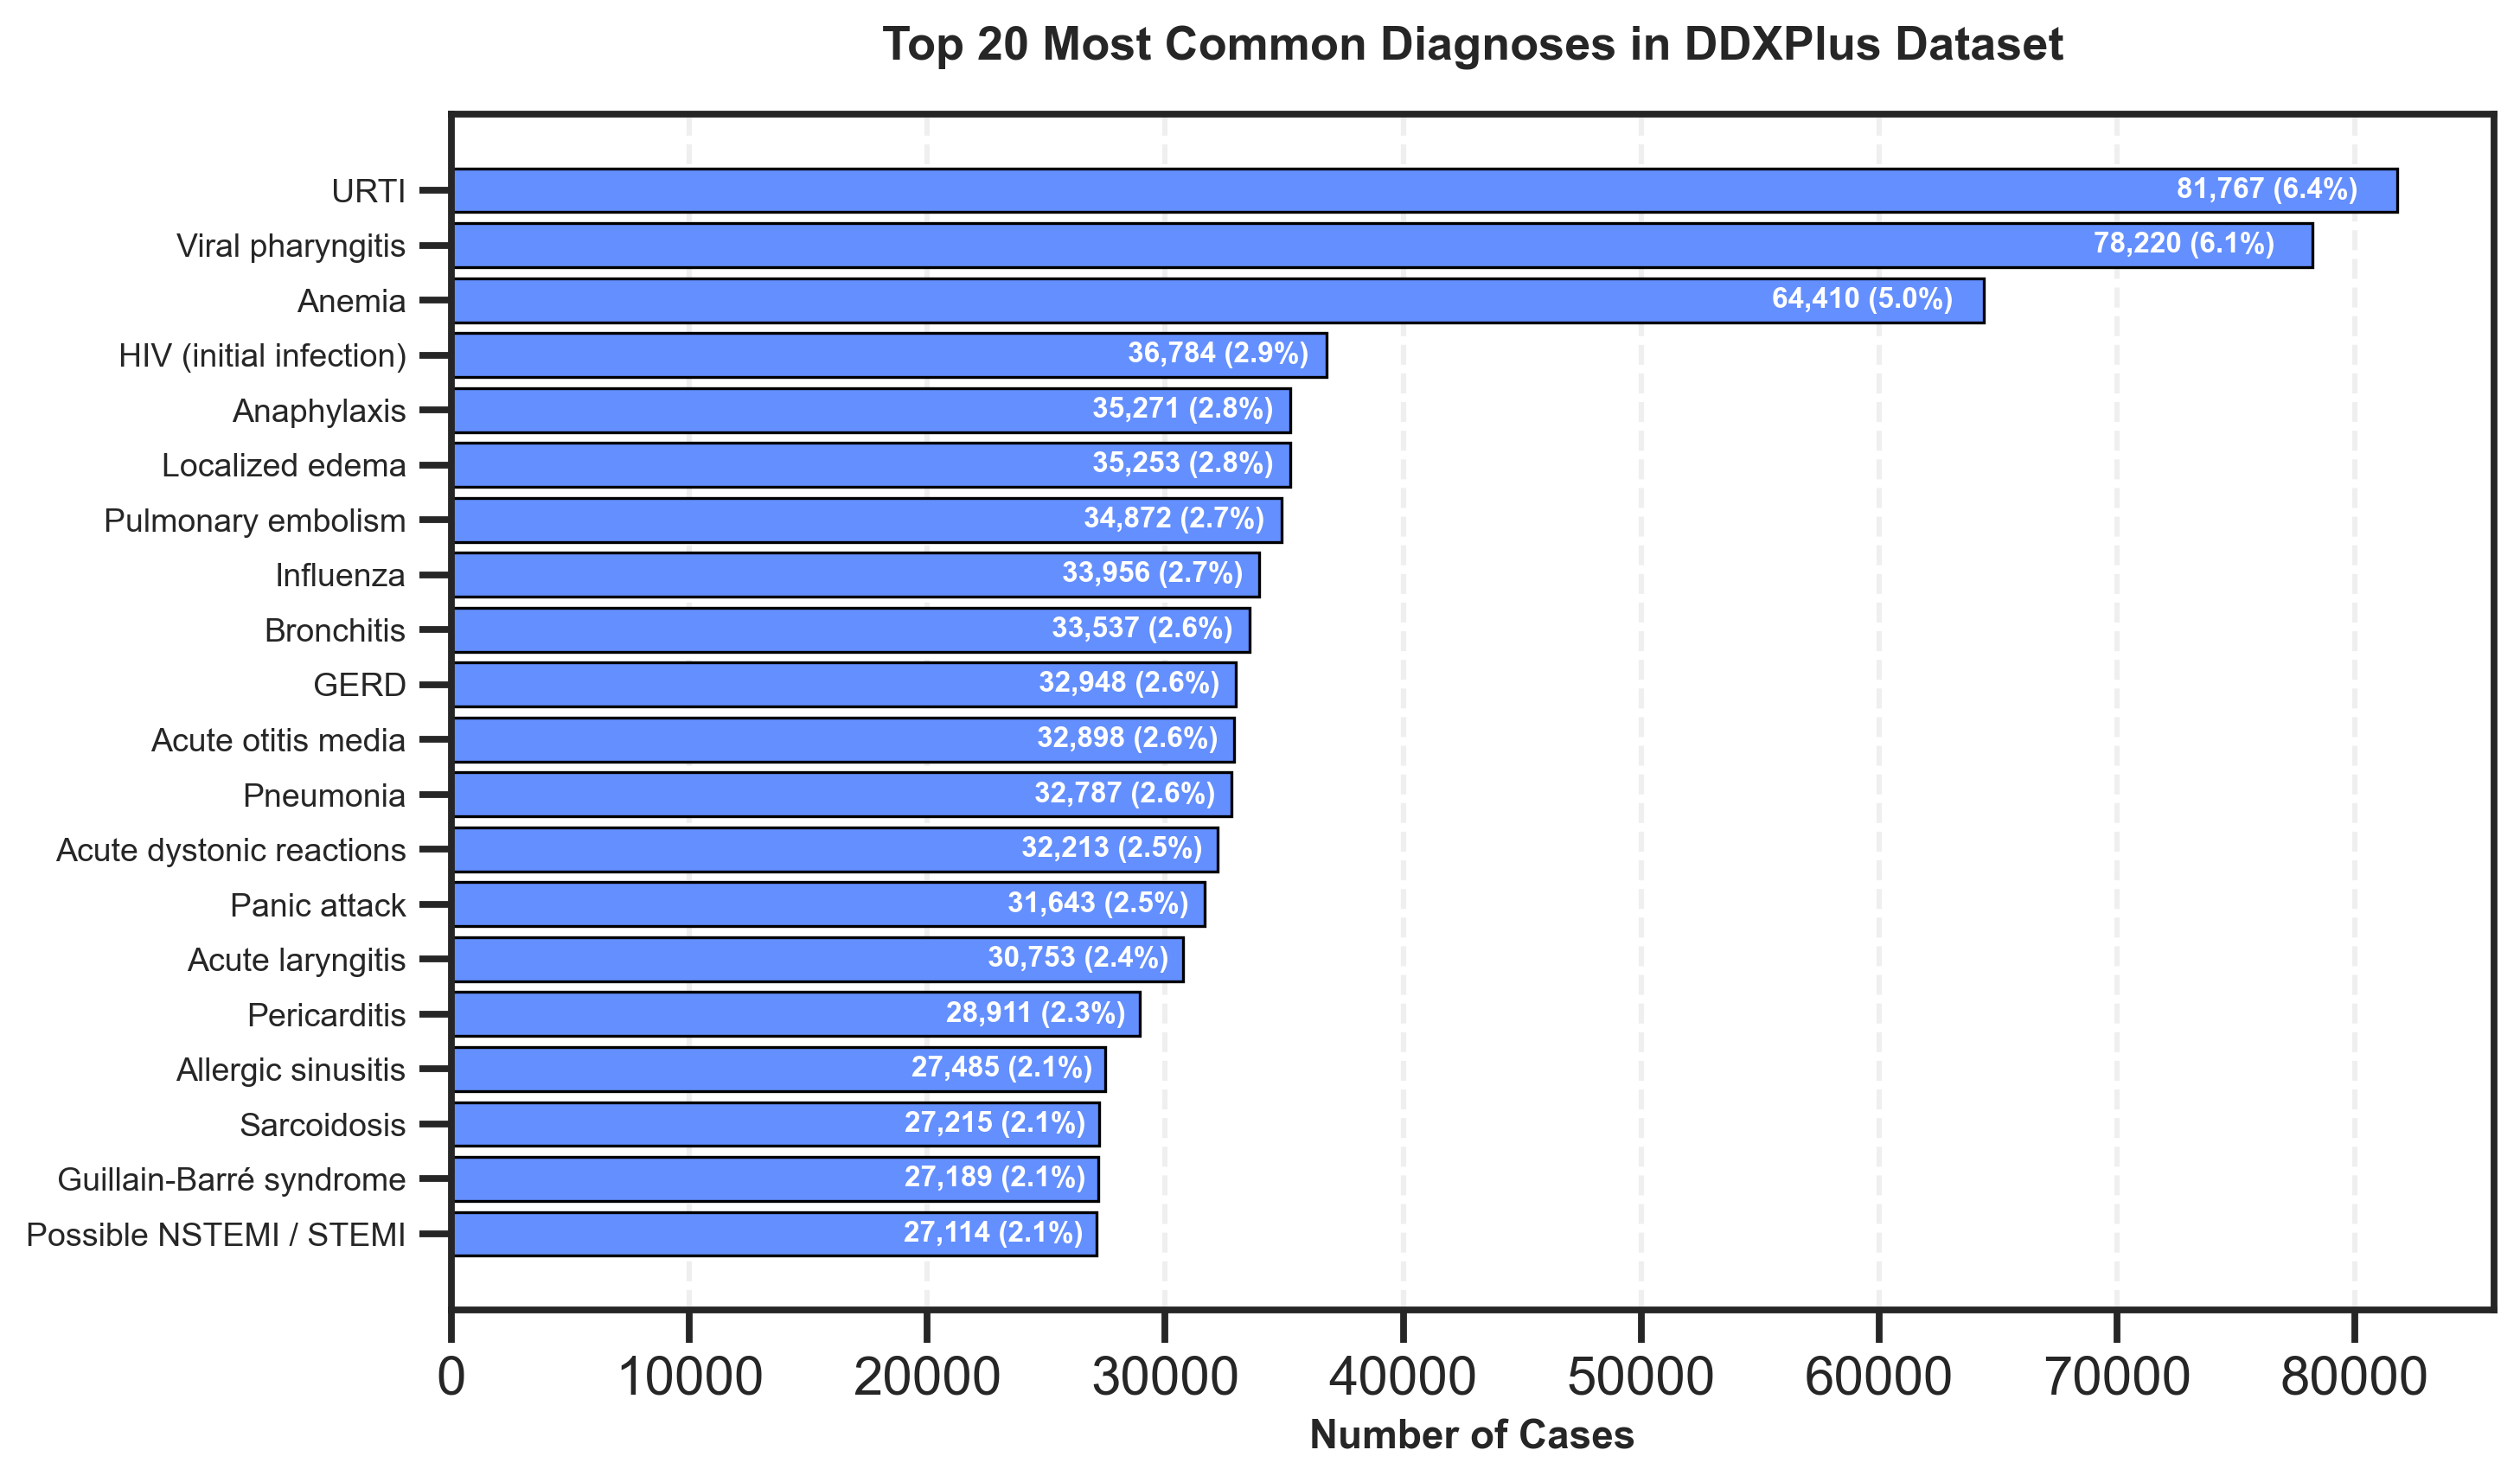

✓ Figure 1 saved: figures/01_disease_distribution.png


In [49]:
# Figure 1: Top 20 Diseases by Frequency
fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE, dpi=DPI)

top_20 = disease_counts.head(20)
total_cases = len(df_all)

bars = ax.barh(range(len(top_20)), top_20.values, color=IBM_COLORS['blue'], edgecolor='black', linewidth=0.8)

# Formatting
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20.index, fontsize=9)
ax.set_xlabel('Number of Cases', fontsize=11, fontweight='bold')
ax.set_title('Top 20 Most Common Diagnoses in DDXPlus Dataset', 
             fontsize=13, fontweight='bold', pad=15)
ax.invert_yaxis()

# Add value labels INSIDE bars (right-aligned, white text)
for i, (idx, val) in enumerate(top_20.items()):
    percentage = (val / total_cases) * 100
    label = f'{val:,} ({percentage:.1f}%)'
    
    # Place text inside the bar, 98% from the left edge
    ax.text(val * 0.98, i, label, va='center', ha='right', 
            fontsize=8, color='white', fontweight='bold')

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('figures/01_disease_distribution.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: figures/01_disease_distribution.png")


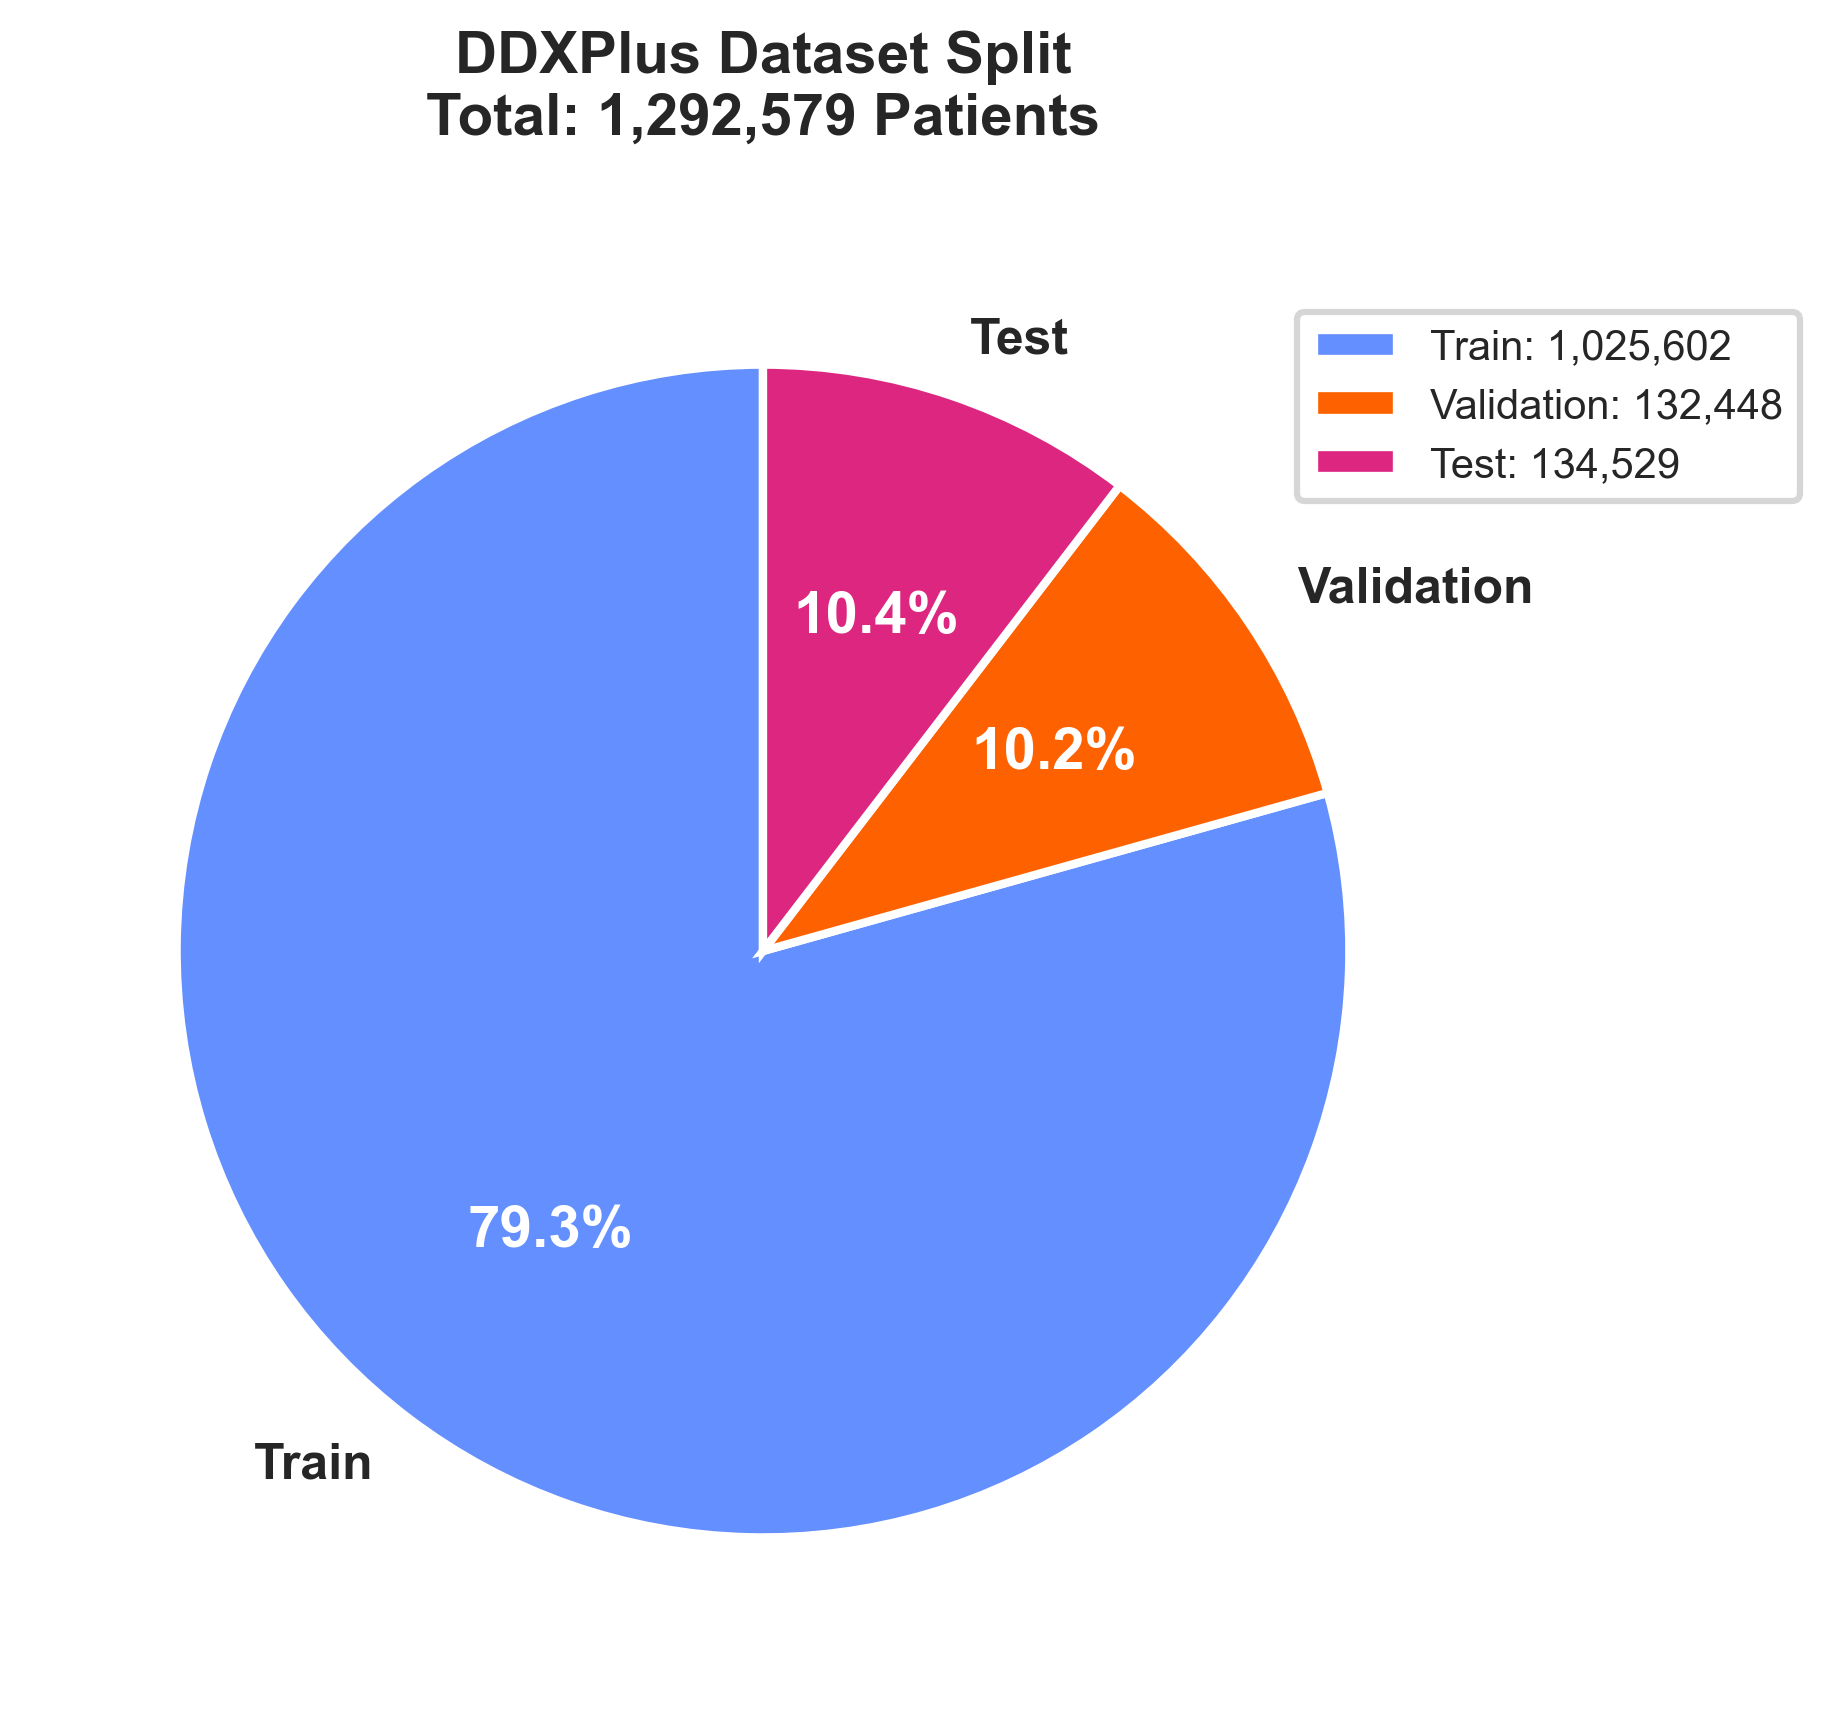

Split proportions:
  Train: 1,025,602 (79.3%)
  Validation: 132,448 (10.2%)
  Test: 134,529 (10.4%)


In [50]:
# Dataset split visualization
fig, ax = plt.subplots(figsize=FIGSIZE_SINGLE, dpi=DPI)

# Data
splits = ['Train', 'Validation', 'Test']
sizes = [len(dataset['train']), len(dataset['validate']), len(dataset['test'])]
percentages = [s/sum(sizes)*100 for s in sizes]
colors_split = [IBM_COLORS['blue'], IBM_COLORS['orange'], IBM_COLORS['magenta']]


# Pie chart
wedges, texts, autotexts = ax.pie(
    sizes, 
    labels=splits,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors_split,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Make percentage text white and bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')

# Title
ax.set_title('DDXPlus Dataset Split\nTotal: 1,292,579 Patients', 
             fontsize=14, fontweight='bold', pad=20)

# Add legend with actual counts
legend_labels = [f'{split}: {size:,}' for split, size in zip(splits, sizes)]
ax.legend(legend_labels, loc='upper left', bbox_to_anchor=(0.85, 0.95), 
          frameon=True, fontsize=10)

plt.tight_layout()
plt.savefig('figures/02_dataset_split.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("Split proportions:")
for split, size, pct in zip(splits, sizes, percentages):
    print(f"  {split}: {size:,} ({pct:.1f}%)")

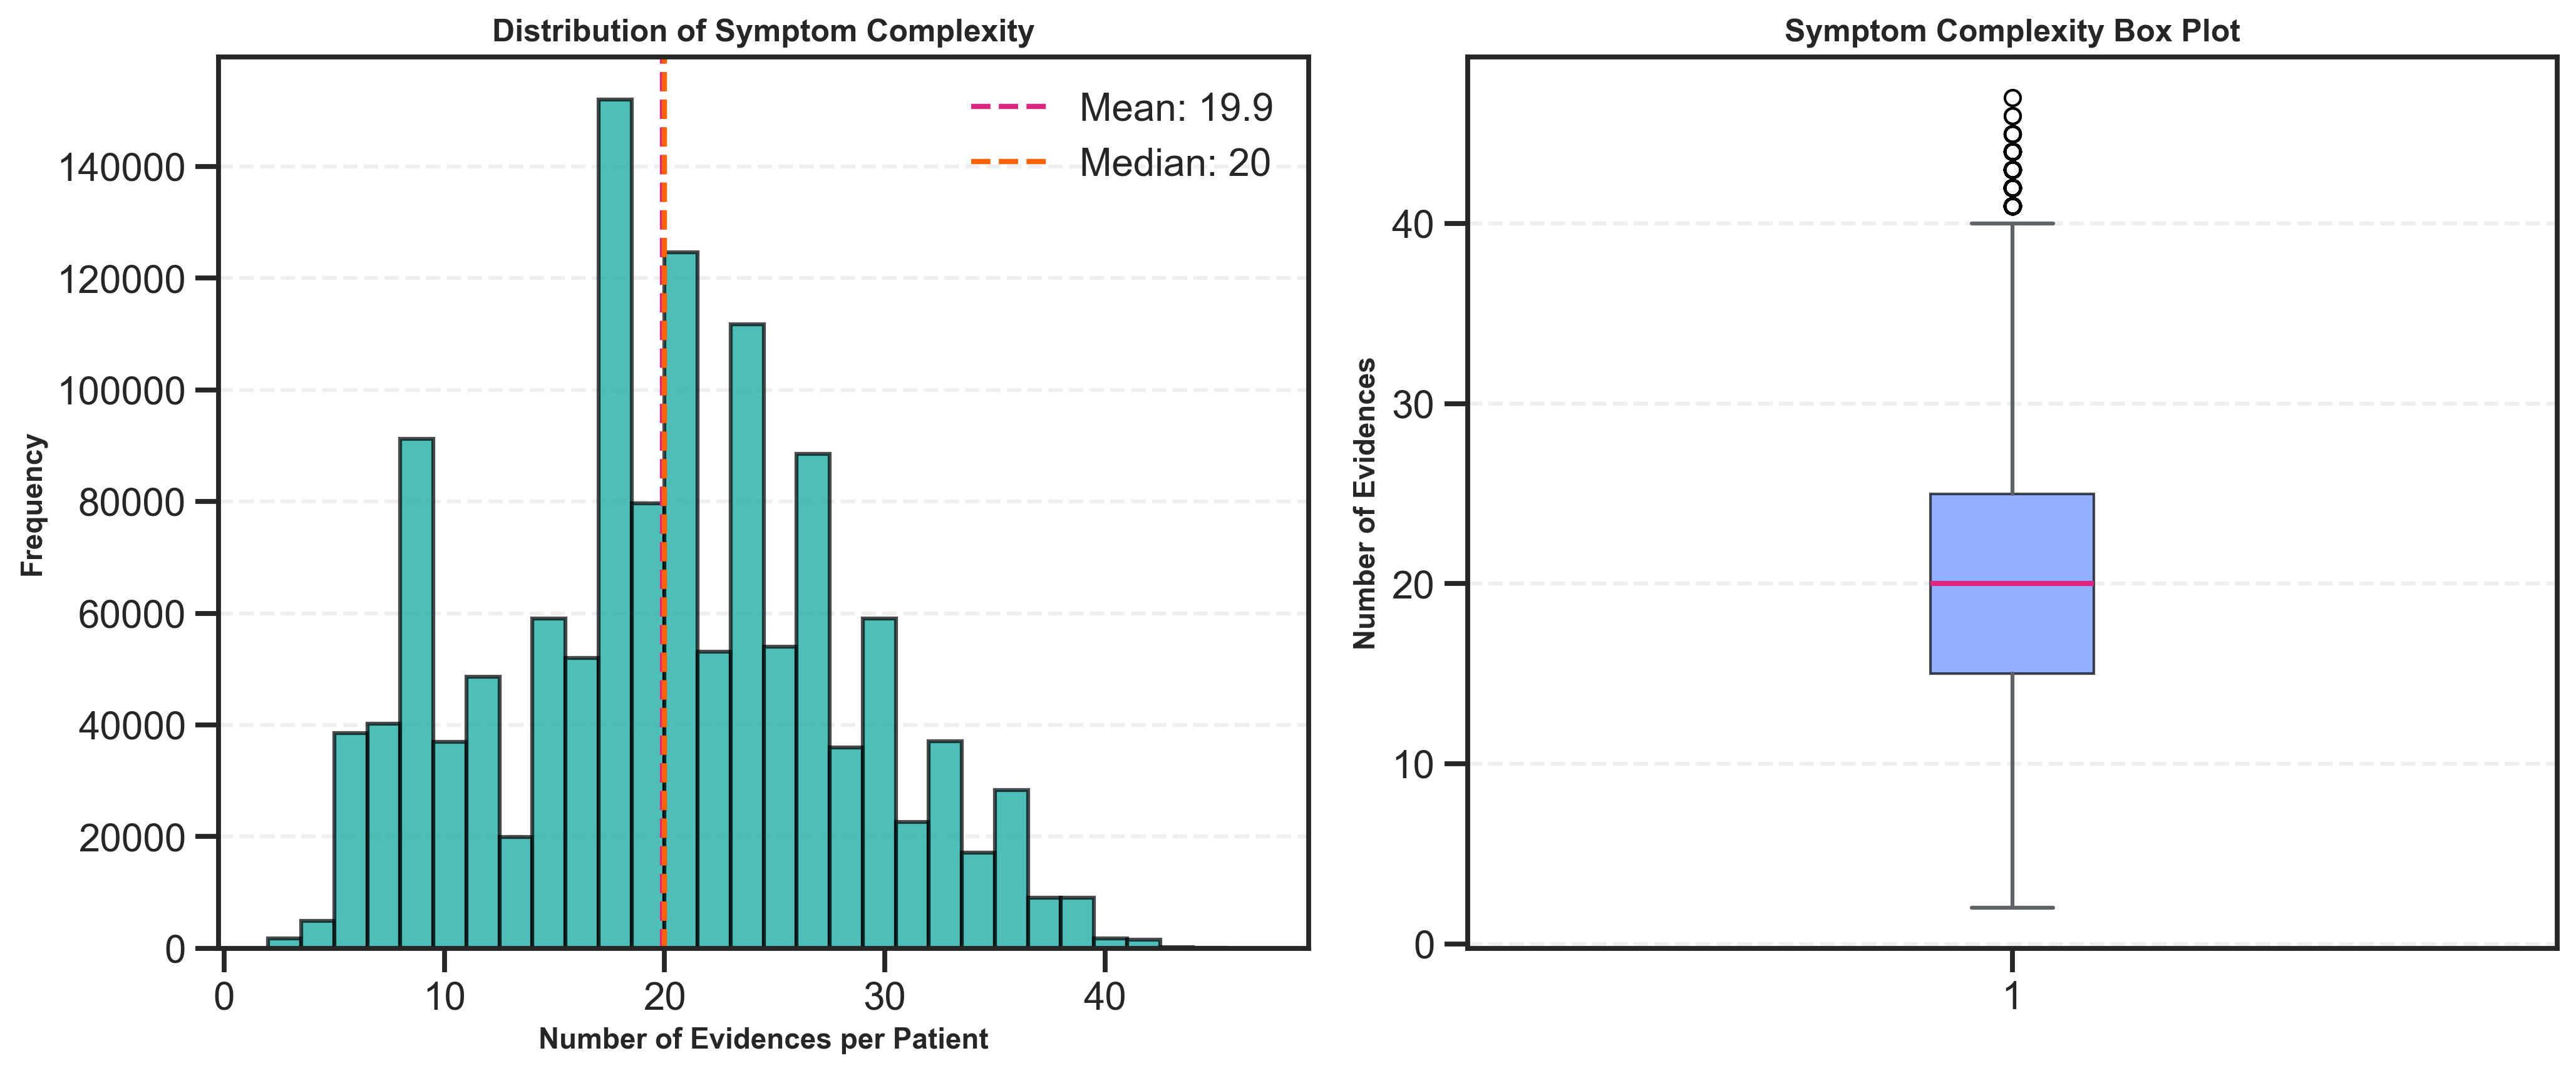

✓ Figure 3 saved: figures/03_symptom_complexity.png

Symptom statistics:
  Mean:   19.9
  Median: 20
  Range:  2-47


In [52]:
# Figure 3: Symptom Complexity Distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# Subplot 1: Histogram
ax1.hist(df_all['num_evidences'], bins=30, color=IBM_COLORS['teal'], 
         edgecolor='black', alpha=0.7)

ax1.axvline(df_all['num_evidences'].mean(), color=IBM_COLORS['magenta'], 
           linestyle='--', linewidth=2, label=f'Mean: {df_all["num_evidences"].mean():.1f}')
ax1.axvline(df_all['num_evidences'].median(), color=IBM_COLORS['orange'], 
           linestyle='--', linewidth=2, label=f'Median: {df_all["num_evidences"].median():.0f}')

ax1.set_xlabel('Number of Evidences per Patient', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Symptom Complexity', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Subplot 2: Box plot
ax2.boxplot(df_all['num_evidences'], vert=True, patch_artist=True,
           boxprops=dict(facecolor=IBM_COLORS['blue'], alpha=0.7),
           medianprops=dict(color=IBM_COLORS['magenta'], linewidth=2),
           whiskerprops=dict(color=IBM_COLORS['gray'], linewidth=1.5),
           capprops=dict(color=IBM_COLORS['gray'], linewidth=1.5))

ax2.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax2.set_title('Symptom Complexity Box Plot', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('figures/03_symptom_complexity.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: figures/03_symptom_complexity.png")
print(f"\nSymptom statistics:")
print(f"  Mean:   {df_all['num_evidences'].mean():.1f}")
print(f"  Median: {df_all['num_evidences'].median():.0f}")
print(f"  Range:  {df_all['num_evidences'].min()}-{df_all['num_evidences'].max()}")


C:\Users\julia\AppData\Local\Temp\ipykernel_3572\1000609736.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(age_symptom_data, labels=['0-17', '18-34', '35-49', '50-64', '65+'],
C:\Users\julia\AppData\Local\Temp\ipykernel_3572\1000609736.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(sex_symptom_data, labels=['Male', 'Female'],


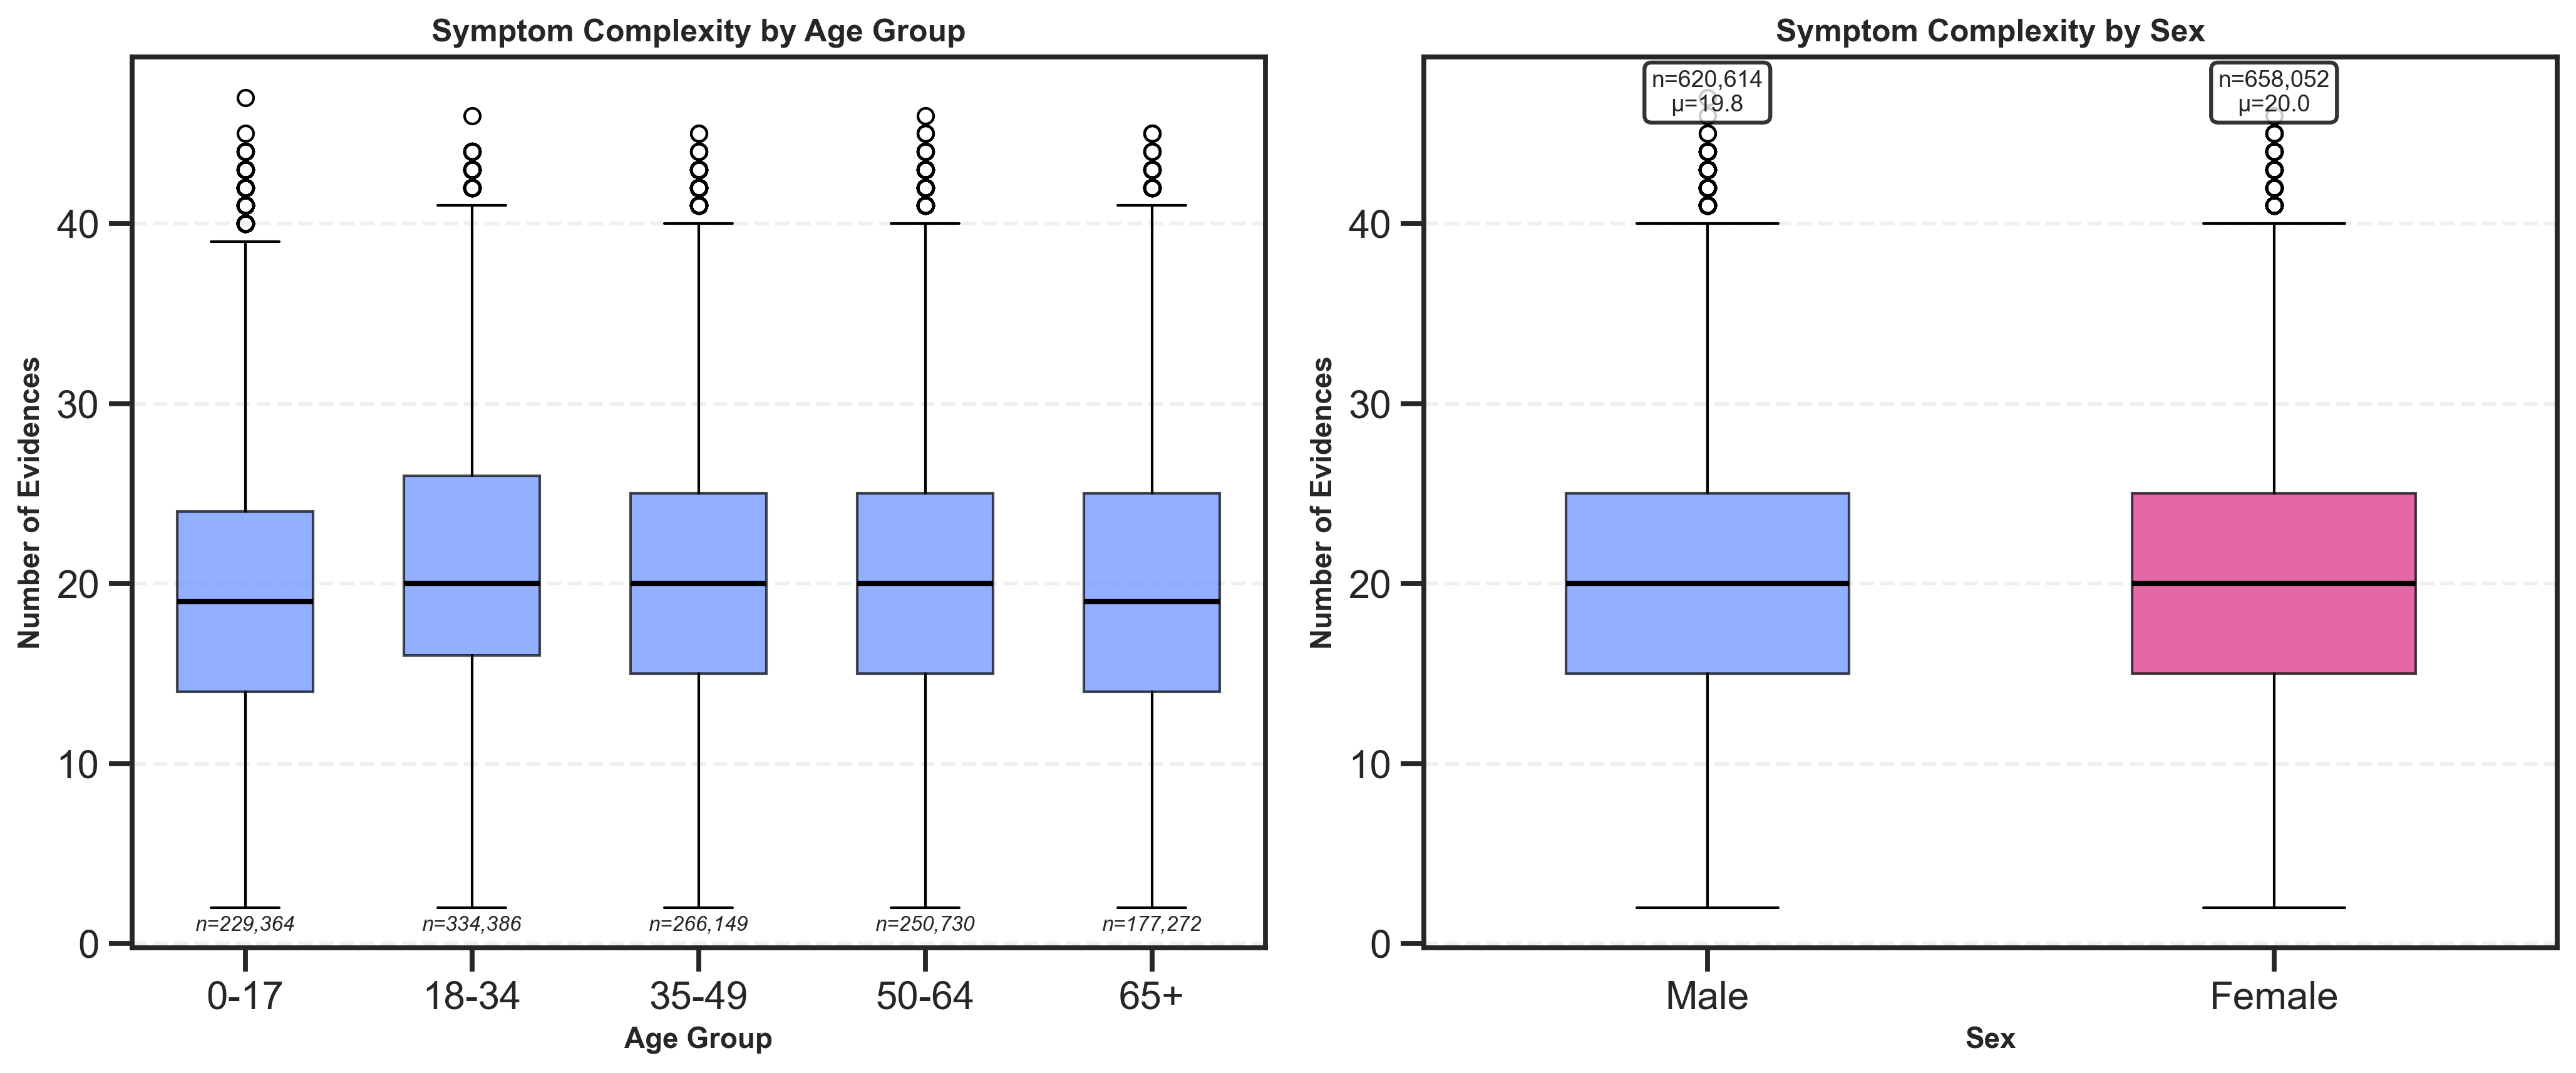

✓ Figure 4 saved: figures/04_symptom_complexity_demographics.png


In [56]:
# Figure 4: Symptom Complexity by Demographics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# LEFT: Symptoms by Age Groups
# Create age bins
df_all['age_group'] = pd.cut(df_all['AGE'], 
                               bins=[0, 18, 35, 50, 65, 110],
                               labels=['0-17', '18-34', '35-49', '50-64', '65+'])

age_symptom_data = [df_all[df_all['age_group'] == group]['num_evidences'].values 
                    for group in ['0-17', '18-34', '35-49', '50-64', '65+']]

bp1 = ax1.boxplot(age_symptom_data, labels=['0-17', '18-34', '35-49', '50-64', '65+'],
                   patch_artist=True, widths=0.6)

# Color boxes
for patch in bp1['boxes']:
    patch.set_facecolor(IBM_COLORS['blue'])
    patch.set_alpha(0.7)
for median in bp1['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax1.set_xlabel('Age Group', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax1.set_title('Symptom Complexity by Age Group', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# Add sample sizes
for i, group in enumerate(['0-17', '18-34', '35-49', '50-64', '65+']):
    n = len(df_all[df_all['age_group'] == group])
    ax1.text(i+1, ax1.get_ylim()[0] + 1, f'n={n:,}', 
            ha='center', fontsize=8, style='italic')

# RIGHT: Symptoms by Sex
sex_symptom_data = [df_all[df_all['SEX'] == sex]['num_evidences'].values 
                    for sex in ['M', 'F']]

bp2 = ax2.boxplot(sex_symptom_data, labels=['Male', 'Female'],
                   patch_artist=True, widths=0.5)

# Color boxes differently
bp2['boxes'][0].set_facecolor(IBM_COLORS['blue'])
bp2['boxes'][1].set_facecolor(IBM_COLORS['magenta'])
for patch in bp2['boxes']:
    patch.set_alpha(0.7)
for median in bp2['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.set_xlabel('Sex', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Evidences', fontsize=11, fontweight='bold')
ax2.set_title('Symptom Complexity by Sex', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Add statistics
for i, sex in enumerate(['M', 'F']):
    data = df_all[df_all['SEX'] == sex]['num_evidences']
    n = len(data)
    mean = data.mean()
    ax2.text(i+1, ax2.get_ylim()[1] - 3, 
            f'n={n:,}\nμ={mean:.1f}', 
            ha='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/04_symptom_complexity_demographics.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved: figures/04_symptom_complexity_demographics.png")

# Drop temporary column
df_all.drop('age_group', axis=1, inplace=True)


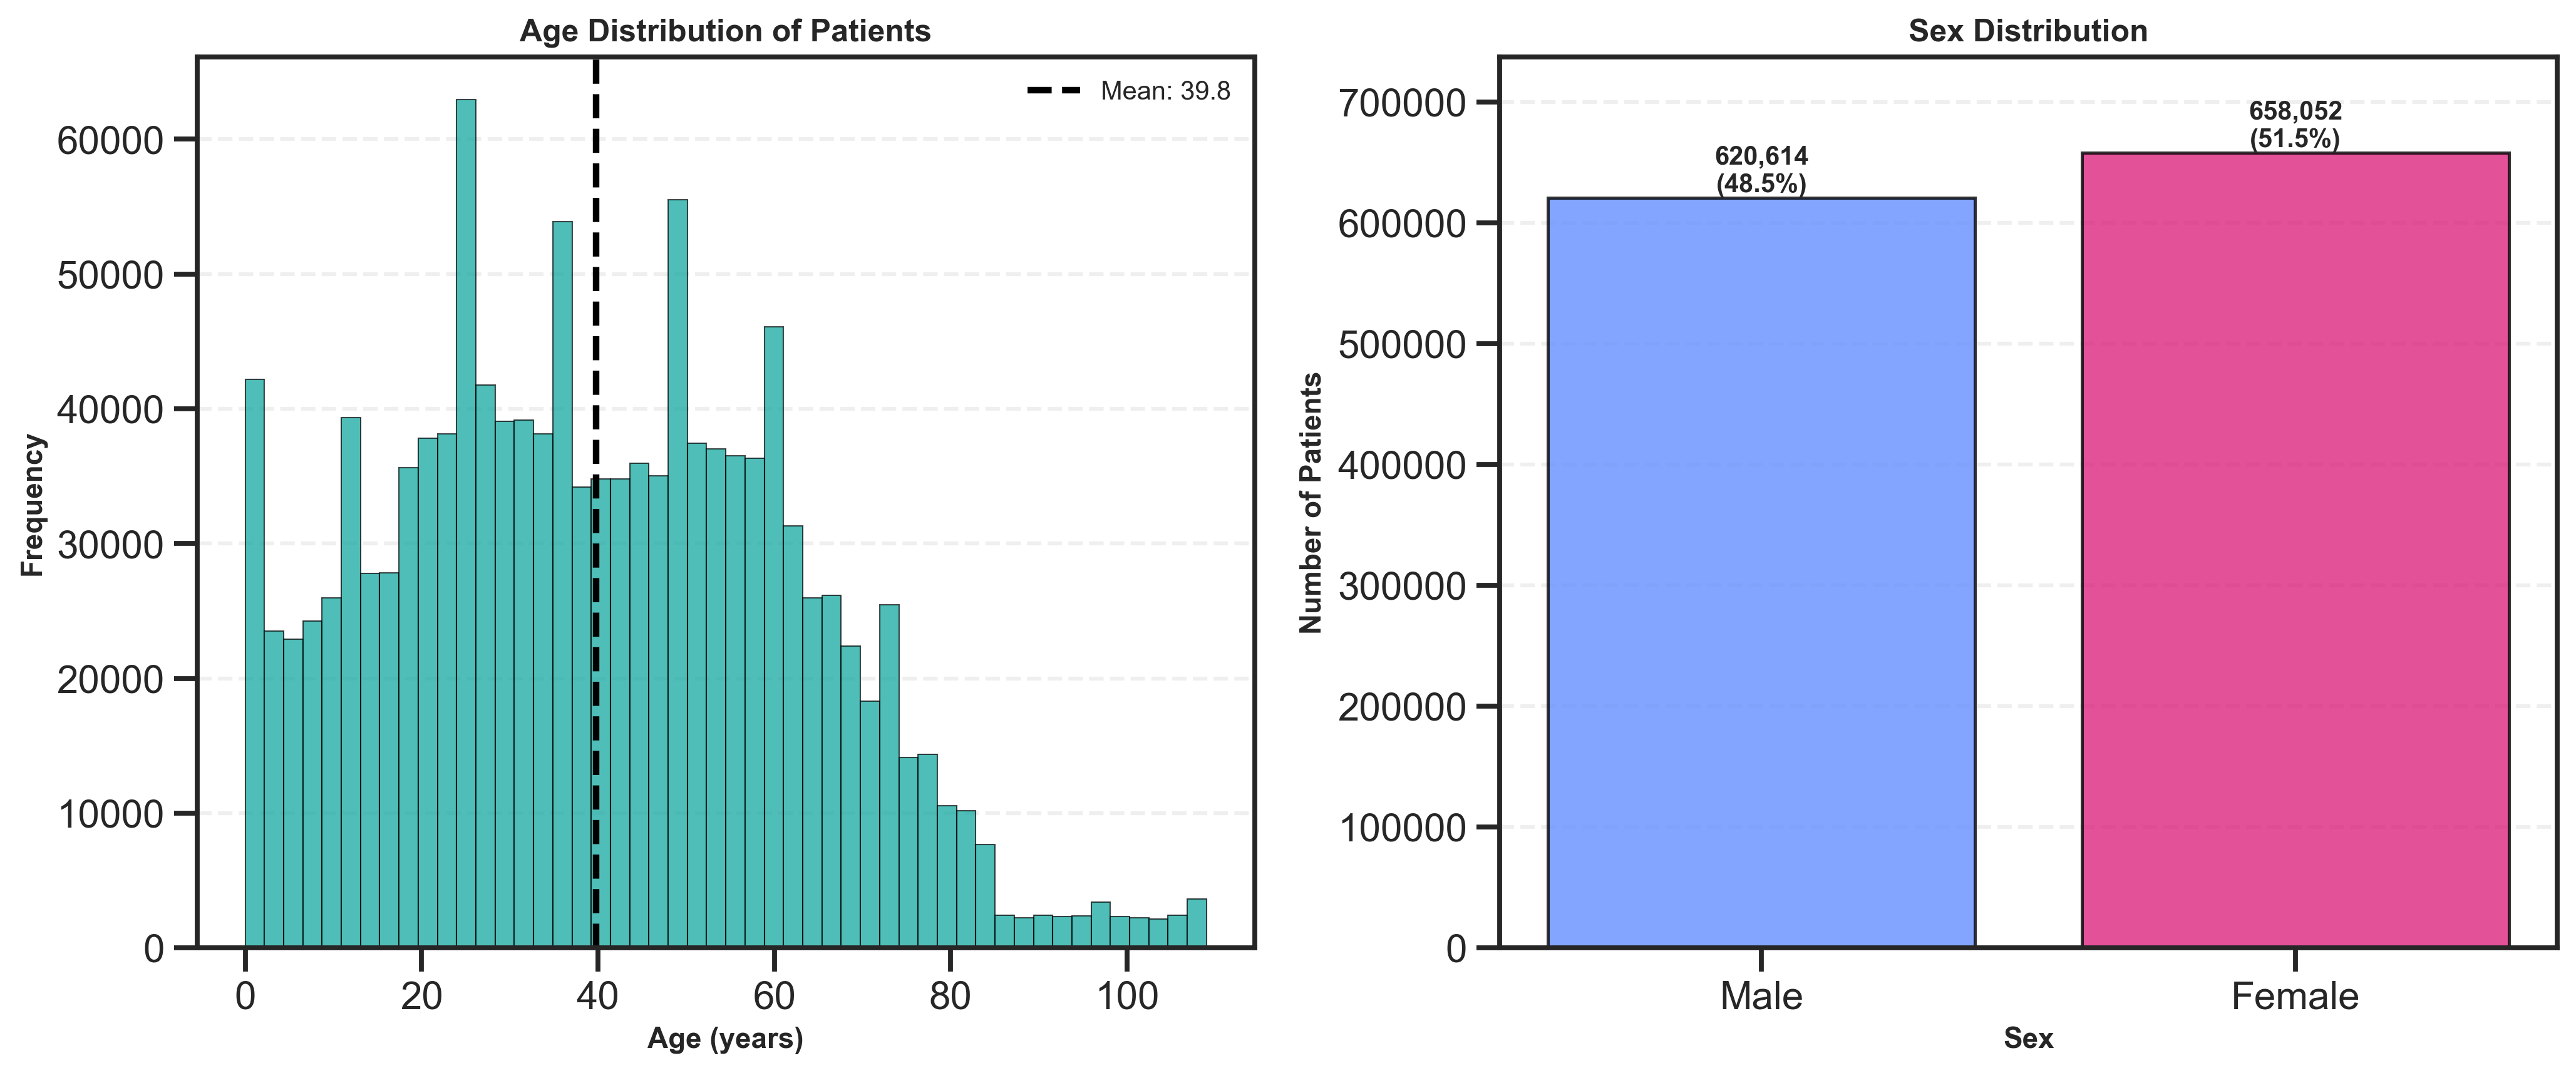

✓ Figure 5 saved: figures/05_demographics.png


In [57]:
# Figure 5: Demographics Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGSIZE_DOUBLE, dpi=DPI)

# LEFT: Age distribution
ax1.hist(df_all['AGE'], bins=50, color=IBM_COLORS['teal'], 
         edgecolor='black', alpha=0.7, linewidth=0.5)

# Mean line (black)
mean_age = df_all['AGE'].mean()
ax1.axvline(mean_age, color='black', 
           linestyle='--', linewidth=2.5, label=f'Mean: {mean_age:.1f}')

ax1.set_xlabel('Age (years)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Age Distribution of Patients', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_axisbelow(True)

# RIGHT: Sex distribution
sex_counts = df_all['SEX'].value_counts()
# Order: Male first, then Female (to match colors with Figure 3)
sex_order = ['M', 'F']
sex_labels = ['Male', 'Female']
sex_values = [sex_counts['M'], sex_counts['F']]
colors_sex = [IBM_COLORS['blue'], IBM_COLORS['magenta']]

bars = ax2.bar(sex_labels, sex_values, color=colors_sex, 
              edgecolor='black', linewidth=1.2, alpha=0.8)

ax2.set_xlabel('Sex', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Patients', fontsize=11, fontweight='bold')
ax2.set_title('Sex Distribution', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_axisbelow(True)

# Set y-limit for better proportions
ax2.set_ylim(0, max(sex_values) * 1.12)

# Add value labels ON TOP of bars
for bar, value in zip(bars, sex_values):
    height = bar.get_height()
    percentage = (value / len(df_all)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:,}\n({percentage:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/05_demographics.png', dpi=DPI, bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved: figures/05_demographics.png")


## 5. Evidence & Condition Analysis

**Purpose:** Understand symptom/finding structure and condition mappings for feature engineering.


In [19]:
# Examine mapping file structure
print("="*70)
print("MAPPING FILE STRUCTURE")
print("="*70)

# Example evidence (binary)
print("\nExample Evidence (Binary):")
example_binary = 'E_91'
print(f"Code: {example_binary}")
print(json.dumps(evidences[example_binary], indent=2))

# Example evidence (categorical)
print("\nExample Evidence (Categorical):")
example_cat = list(evidences.keys())[50]  # Pick one with values
if 'value_meaning' in evidences[example_cat]:
    print(f"Code: {example_cat}")
    print(json.dumps(evidences[example_cat], indent=2))

# Example condition
print("\nExample Condition:")
example_cond = 'URTI'
print(f"Code: {example_cond}")
print(json.dumps(conditions[example_cond], indent=2))


MAPPING FILE STRUCTURE

Example Evidence (Binary):
Code: E_91
{
  "name": "E_91",
  "code_question": "E_91",
  "question_fr": "Avez-vous objectiv\u00e9 ou ressenti de la fi\u00e8vre?",
  "question_en": "Do you have a fever (either felt or measured with a thermometer)?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}

Example Evidence (Categorical):
Code: E_96
{
  "name": "E_96",
  "code_question": "E_96",
  "question_fr": "Avez-vous pris du poids r\u00e9cemment?",
  "question_en": "Have you gained weight recently?",
  "is_antecedent": false,
  "default_value": 0,
  "value_meaning": {},
  "possible-values": [],
  "data_type": "B"
}

Example Condition:
Code: URTI
{
  "condition_name": "URTI",
  "cond-name-fr": "IVRS ou vir\u00e9mie",
  "cond-name-eng": "URTI",
  "icd10-id": "j06.9",
  "symptoms": {
    "E_55": {},
    "E_53": {},
    "E_57": {},
    "E_54": {},
    "E_59": {},
    "E_56": {},
    "E_58": {},
    "E_201

In [20]:
# Analyze evidence data types and structure
print("="*70)
print("EVIDENCE TYPE ANALYSIS")
print("="*70)

# Count by data type
binary_evidences = []
categorical_evidences = []
multichoice_evidences = []

for code, info in evidences.items():
    dtype = info['data_type']
    if dtype == 'B':
        binary_evidences.append(code)
    elif dtype == 'C':
        categorical_evidences.append(code)
    elif dtype == 'M':
        multichoice_evidences.append(code)

print(f"\nTotal evidences: {len(evidences)}")
print(f"  Binary (B):      {len(binary_evidences):>3}")
print(f"  Categorical (C): {len(categorical_evidences):>3}")
print(f"  Multi-choice (M): {len(multichoice_evidences):>3}")

# Find categorical evidences with actual values
categorical_with_values = [
    code for code in categorical_evidences 
    if evidences[code]['value_meaning']
]

print(f"\nCategorical evidences with value mappings: {len(categorical_with_values)}")


EVIDENCE TYPE ANALYSIS

Total evidences: 223
  Binary (B):      208
  Categorical (C):  10
  Multi-choice (M):   5

Categorical evidences with value mappings: 4


In [21]:
# Display examples of each evidence type
print("\n" + "="*70)
print("EVIDENCE EXAMPLES")
print("="*70)

# Binary examples
print("\n1. BINARY EVIDENCES (Yes/No questions)")
print("-" * 70)

for i, code in enumerate(binary_evidences[:3], 1):
    ev = evidences[code]
    print(f"\nExample {i}: {code}")
    print(f"  Question: {ev['question_en']}")
    print(f"  Is antecedent: {ev['is_antecedent']}")
    print(f"  Default value: {ev['default_value']}")

# Categorical examples
if categorical_with_values:
    print("\n\n2. CATEGORICAL EVIDENCES (Multiple choice questions)")
    print("-" * 70)
    
    for i, code in enumerate(categorical_with_values[:3], 1):
        ev = evidences[code]
        print(f"\nExample {i}: {code}")
        print(f"  Question: {ev['question_en']}")
        print(f"  Is antecedent: {ev['is_antecedent']}")
        print(f"  Possible values: {ev['possible-values'][:5]}")  # First 5
        print(f"  Value meanings (sample):")
        # Show first 3 value meanings
        for j, (val_code, meaning) in enumerate(list(ev['value_meaning'].items())[:3], 1):
            print(f"    {val_code}: {meaning}")
        if len(ev['value_meaning']) > 3:
            print(f"    ... and {len(ev['value_meaning']) - 3} more values")
else:
    print("\n\n2. CATEGORICAL EVIDENCES")
    print("-" * 70)
    print("  No categorical evidences with value mappings found")



EVIDENCE EXAMPLES

1. BINARY EVIDENCES (Yes/No questions)
----------------------------------------------------------------------

Example 1: E_91
  Question: Do you have a fever (either felt or measured with a thermometer)?
  Is antecedent: False
  Default value: 0

Example 2: E_53
  Question: Do you have pain somewhere, related to your reason for consulting?
  Is antecedent: False
  Default value: 0

Example 3: E_159
  Question: Did you lose consciousness?
  Is antecedent: False
  Default value: 0


2. CATEGORICAL EVIDENCES (Multiple choice questions)
----------------------------------------------------------------------

Example 1: E_130
  Question: What color is the rash?
  Is antecedent: False
  Possible values: ['V_11', 'V_86', 'V_107', 'V_138', 'V_156']
  Value meanings (sample):
    V_11: {'fr': 'NA', 'en': 'NA'}
    V_86: {'fr': 'foncée', 'en': 'dark'}
    V_107: {'fr': 'jaune', 'en': 'yellow'}
    ... and 3 more values

Example 2: E_135
  Question: Is the lesion (or are the l

In [22]:
# Analyze antecedents (risk factors vs symptoms)
print("\n" + "="*70)
print("ANTECEDENT ANALYSIS")
print("="*70)

antecedents = [code for code, info in evidences.items() if info['is_antecedent']]
symptoms = [code for code, info in evidences.items() if not info['is_antecedent']]

print(f"\nAntecedents (risk factors):  {len(antecedents):>3}")
print(f"Symptoms (current findings): {len(symptoms):>3}")

print("\nExample Antecedents (Risk Factors):")
for code in antecedents[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")

print("\nExample Symptoms (Current Findings):")
for code in symptoms[:3]:
    print(f"  - {code}: {evidences[code]['question_en']}")



ANTECEDENT ANALYSIS

Antecedents (risk factors):  113
Symptoms (current findings): 110

Example Antecedents (Risk Factors):
  - E_16: Do you feel anxious?
  - E_102: Are you consulting because you have high blood pressure?
  - E_196: Have you had surgery within the last month?

Example Symptoms (Current Findings):
  - E_91: Do you have a fever (either felt or measured with a thermometer)?
  - E_55: Do you feel pain somewhere?
  - E_53: Do you have pain somewhere, related to your reason for consulting?


---

### Evidence Structure Summary

#### Overview

The DDXPlus dataset contains **223 evidence codes** representing symptoms and risk factors.

| Type | Count | % | Description |
|------|------:|--:|-------------|
| Binary (B) | 208 | 93% | Yes/No questions |
| Categorical (C) | 10 | 4% | Multiple choice (with values) |
| Multi-choice (M) | 5 | 2% | Multiple selections possible |
| **Total** | **223** | **100%** | |

**Note:** Only 4 categorical evidences have value mappings (others are simple binary).

---

#### Evidence Categories

| Category | Count | Purpose |
|----------|------:|---------|
| **Antecedents** | 113 | Risk factors (medical history, demographics, behaviors) |
| **Symptoms** | 110 | Current clinical findings (fever, pain, etc.) |

**Examples:**
- **Antecedents:** Anxiety, high blood pressure history, recent surgery
- **Symptoms:** Fever, pain, loss of consciousness

---


#### Data Structure

**Binary evidence:**  
E_91 → "Do you have a fever?"  
Values: 0 (no) or 1 (yes)  

**Categorical evidence:**
E_130 @ V_86 → "What color is the rash?" → "dark"
Format: code @ value_code


---

#### Key Observations

1. **Predominantly binary** (93%) - Most features are simple yes/no
2. **Balanced split** - Almost equal antecedents (113) vs symptoms (110)
3. **Categorical values** - Only 4 evidences require value decoding
4. **Default = absent** - All evidences assume 0 (not present) unless explicitly listed

---

#### Implications for Preprocessing

- Binary evidences → One-hot encoding (presence/absence)
- Categorical evidences → Parse `code @ value` format, decode values
- Antecedents vs symptoms → May benefit from separate feature groups
- Missing evidences → Treat as 0 (default assumption built into dataset)

---


#### Initial visualization of the dataset

#### Exploring inconsistencies 

Initial symptom is defined as 1 symptom.I would like to validate if initial symptom is always included in the final evidence column.

In [34]:
# Check: Is INITIAL_EVIDENCE always in the EVIDENCES list?
print("Verifying INITIAL_EVIDENCE definition...")

# Test: Is initial evidence always part of all evidences?
def check_initial_in_evidences(row):
    initial = row['INITIAL_EVIDENCE']
    evidences = row['EVIDENCES']
    return initial in evidences

in_list = df_all.apply(check_initial_in_evidences, axis=1)

print(f"\nIs INITIAL_EVIDENCE always in EVIDENCES list?")
print(f"  Yes: {in_list.sum():,} patients ({in_list.sum()/len(df_all)*100:.1f}%)")
print(f"  No:  {(~in_list).sum():,} patients ({(~in_list).sum()/len(df_all)*100:.1f}%)")

if in_list.all():
    print("\n✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES")
    print("  → It's the 'chief complaint' - what patient presented with")
else:
    print("\n⚠ WARNING: INITIAL_EVIDENCE sometimes NOT in EVIDENCES list")
    print("  → May have different meaning than 'first symptom'")

# Check a few examples
print("\n\nExample patients:")
for i in range(3):
    patient = df_all.iloc[i]
    print(f"\nPatient {i}:")
    print(f"  Initial: {patient['INITIAL_EVIDENCE']}")
    print(f"  All evidences: {patient['EVIDENCES'][:5]}...")
    print(f"  Is initial in list? {patient['INITIAL_EVIDENCE'] in patient['EVIDENCES']}")


Verifying INITIAL_EVIDENCE definition...

Is INITIAL_EVIDENCE always in EVIDENCES list?
  Yes: 1,292,579 patients (100.0%)
  No:  0 patients (0.0%)

✓ CONFIRMED: INITIAL_EVIDENCE is always included in EVIDENCES
  → It's the 'chief complaint' - what patient presented with


Example patients:

Patient 0:
  Initial: E_91
  All evidences: ['E_4...
  Is initial in list? True

Patient 1:
  Initial: E_50
  All evidences: ['E_9...
  Is initial in list? True

Patient 2:
  Initial: E_77
  All evidences: ['E_5...
  Is initial in list? True


Next, we will look into evidences per patient (mean is 242).

In [35]:
# Deep dive into EVIDENCES structure
print("="*70)
print("INVESTIGATING EVIDENCES STRUCTURE")
print("="*70)

# Look at raw data from first patient
patient0 = df_all.iloc[0]

print("\n1. EVIDENCES column type and structure:")
print(f"   Type: {type(patient0['EVIDENCES'])}")
print(f"   Length: {len(patient0['EVIDENCES'])}")

print("\n2. First 20 items in EVIDENCES:")
for i, ev in enumerate(patient0['EVIDENCES'][:20], 1):
    print(f"   {i:2}. {ev}")

print("\n3. Check if it's ALL 223 codes or just present ones:")
print(f"   Total evidence codes in dataset: {len(evidences)}")
print(f"   Patient 0 evidences count: {len(patient0['EVIDENCES'])}")
print(f"   Are they the same? {len(patient0['EVIDENCES']) == len(evidences)}")

print("\n4. Sample 3 more patients:")
for i in range(1, 4):
    print(f"   Patient {i}: {len(df_all.iloc[i]['EVIDENCES'])} evidences")

print("\n5. Check unique lengths:")
unique_lengths = df_all['num_evidences'].value_counts().head(10)
print(unique_lengths)


INVESTIGATING EVIDENCES STRUCTURE

1. EVIDENCES column type and structure:
   Type: <class 'str'>
   Length: 221

2. First 20 items in EVIDENCES:
    1. [
    2. '
    3. E
    4. _
    5. 4
    6. 8
    7. '
    8. ,
    9.  
   10. '
   11. E
   12. _
   13. 5
   14. 0
   15. '
   16. ,
   17.  
   18. '
   19. E
   20. _

3. Check if it's ALL 223 codes or just present ones:
   Total evidence codes in dataset: 223
   Patient 0 evidences count: 221
   Are they the same? False

4. Sample 3 more patients:
   Patient 1: 393 evidences
   Patient 2: 418 evidences
   Patient 3: 205 evidences

5. Check unique lengths:
num_evidences
236    13541
228    12408
244    11770
245    11311
237    11186
220    11100
227    11004
229    10811
77     10622
235    10395
Name: count, dtype: int64


In [36]:
# Fix EVIDENCES column - convert string to actual list
import ast

print("Converting EVIDENCES from string to list...")

df_all['EVIDENCES'] = df_all['EVIDENCES'].apply(ast.literal_eval)

print("✓ Conversion complete")

# NOW count correctly
df_all['num_evidences'] = df_all['EVIDENCES'].apply(len)

print(f"\nRecalculated statistics:")
print(f"  Mean: {df_all['num_evidences'].mean():.1f}")
print(f"  Median: {df_all['num_evidences'].median():.0f}")
print(f"  Min: {df_all['num_evidences'].min()}")
print(f"  Max: {df_all['num_evidences'].max()}")

# Verify by checking first patient
patient0 = df_all.iloc[0]
print(f"\nPatient 0 verification:")
print(f"  Type now: {type(patient0['EVIDENCES'])}")
print(f"  Number of evidences: {len(patient0['EVIDENCES'])}")
print(f"  First 5 evidences: {patient0['EVIDENCES'][:5]}")


Converting EVIDENCES from string to list...
✓ Conversion complete

Recalculated statistics:
  Mean: 19.8
  Median: 20
  Min: 2
  Max: 47

Patient 0 verification:
  Type now: <class 'list'>
  Number of evidences: 19
  First 5 evidences: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183']


In [37]:
# Comprehensive check of all column types
print("="*70)
print("CHECKING ALL COLUMN DATA TYPES")
print("="*70)

print("\nCurrent column types:")
for col in df_all.columns:
    sample = df_all[col].iloc[0]
    print(f"  {col:30} → {type(sample).__name__:15} | Sample: {str(sample)[:60]}")

# Identify which columns need conversion
print("\n" + "="*70)
print("COLUMNS THAT NEED CONVERSION:")
print("="*70)

needs_conversion = []

for col in df_all.columns:
    sample = df_all[col].iloc[0]
    # Check if it's a string that looks like a list or dict
    if isinstance(sample, str) and (sample.startswith('[') or sample.startswith('{')):
        needs_conversion.append(col)
        print(f"  ⚠️  {col} → Currently string, should be list/dict")

if not needs_conversion:
    print("  ✓ All columns have correct types!")


CHECKING ALL COLUMN DATA TYPES

Current column types:
  AGE                            → int64           | Sample: 18
  DIFFERENTIAL_DIAGNOSIS         → str             | Sample: [['Bronchitis', 0.19171203430383882], ['Pneumonia', 0.175793
  SEX                            → str             | Sample: M
  PATHOLOGY                      → str             | Sample: URTI
  EVIDENCES                      → list            | Sample: ['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54_@_V_183', 'E_
  INITIAL_EVIDENCE               → str             | Sample: E_91
  num_evidences                  → int64           | Sample: 19

COLUMNS THAT NEED CONVERSION:
  ⚠️  DIFFERENTIAL_DIAGNOSIS → Currently string, should be list/dict
